<a href="https://colab.research.google.com/github/gpricechristie/introductionToClinicalTrials/blob/main/simulateSurvivalData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulation of a clinical trial cohort to demonstrate trial design
Basic analysis to create simple (non-censored) survival data with simple exponential baseline hazard and hazard to various risk factors that  can be used to demonstrate confounding, randomisation and selection bias.

Patient factors to consider will be
* Age
* Sex
* Performance status
* Cancer stage
* GTV Volume

We will consider lung cancer and take hazard ratio estimates from cardiac toxicity papers (10.1016/j.ejca.2017.07.053). Add in an HR for respose to new radiotherapy regimen
* Age HR - 1.01/year
* Sex HR - (ref female), 1.2
* Performance status HR - (ref 0), 1.3 (1), 1.55 (2), 1.82 (3+)
* Cancer stage HR - (ref 1), 1.3 (2), 1.5 (3), 2.0 (4)
* GTV Volume HR - 1.01 / cm3
* Treatment effect HR - 1.3

The treatment effect will differ for different patient populations. This means the analyses can test
* Effect of randomisation vs observation to determine effect of intervention on study - this will need some confounding that affects who is treated and who isn't. Hospital A vs B where the hospitals serve different demographics.
population
* Use of selection criteria to find those patients the treatment is most effective in
* Selection bias of these results not translating to patients where it is less effective


Load libraries

In [1]:
install.packages("ggsurvfit")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘patchwork’




In [2]:
install.packages("table1")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Formula’




In [3]:
library(survival)
library(ggplot2)
library(ggsurvfit)
library(tidyr)
library(table1)
library(patchwork)
library(dplyr)


Attaching package: ‘table1’


The following objects are masked from ‘package:base’:

    units, units<-



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Set basic parameters


*   Number of patients (nbrPats)
*   Hazards for different factors (hr_X).
*   Baseline hazards (h_0 - uniform as exponential cumulative baseline)



In [47]:
popSize=50000
nbrPats = 1000
hr_age=1.01
hr_sex=1.2
hr_ps1=1.3
hr_ps2=1.55
hr_ps3=1.82
hr_stage2=1.3
hr_stage3=1.5
hr_stage4=2.0
hr_gtv=1.4
hr_treat=1.3
h_0=0.001

Define the distribution of characteristics across the patient population

Start with weighted random assignment approximating distributions seen in Christie data
* Age - normal distribution with mean 70 and sd 10
* PS - sampled with weights 0.15, 0.45, 0.4, 0.1
* stage - sampled with weights 0.5, 0.125, 0.3, 0.075
* sex - sampled with weights 0.4, 0.6
* log gtv - normal distribution with mean 4 and sd 1
* hospital - hospital A serves a younger/fitter/earlier stage demographic vs B which serves an older/frailer/later stage demographic

Use conditionals to create a rough correlation between age and PS, and GTV and stage


In [48]:
set.seed(8734620)

age=rnorm(popSize,mean=70,sd=10)
population=data.frame(age=age)

population<-population %>%
  mutate(ps= factor(case_when(age<quantile(age,0.2)~sample(c(0,1,2,3),n(), replace = TRUE, prob=c(0.25, 0.55, 0.15, 0.05)),
                       age<quantile(age,0.4)~sample(c(0,1,2,3),n(), replace = TRUE, prob=c(0.2, 0.5, 0.2, 0.1)),
                       age<quantile(age,0.6)~sample(c(0,1,2,3),n(), replace = TRUE, prob=c(0.15, 0.45, 0.4, 0.1)),
                       age<quantile(age,0.8)~sample(c(0,1,2,3),n(), replace = TRUE, prob=c(0.1, 0.3, 0.45, 0.15)),
                       TRUE~sample(c(0,1,2,3),n(), replace = TRUE, prob=c(0.05, 0.3, 0.5, 0.15)))))

sex=sample(c('male','female'), popSize, replace=TRUE, prob=c(0.6, 0.4))
population$sex=factor(sex)

logGtv = rnorm(popSize,mean=3, sd=1)
population$gtv=exp(logGtv)

population<-population %>%
  mutate(stage= factor(case_when(logGtv<quantile(logGtv,0.2)~sample(c(1,2,3,4),n(), replace = TRUE, prob=c(0.55, 0.25, 0.15, 0.05)),
                          logGtv<quantile(logGtv,0.4)~sample(c(1,2,3,4),n(), replace = TRUE, prob=c(0.5, 0.2, 0.25, 0.05)),
                          logGtv<quantile(logGtv,0.6)~sample(c(1,2,3,4),n(), replace = TRUE, prob=c(0.4, 0.175, 0.35, 0.075)),
                          logGtv<quantile(logGtv,0.8)~sample(c(1,2,3,4),n(), replace = TRUE, prob=c(0.35, 0.15, 0.4, 0.1)),
                          TRUE~sample(c(1,2,3,4),n(), replace = TRUE, prob=c(0.25, 0.1, 0.5, 0.15)))))


Warning message:
“Removed 537 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


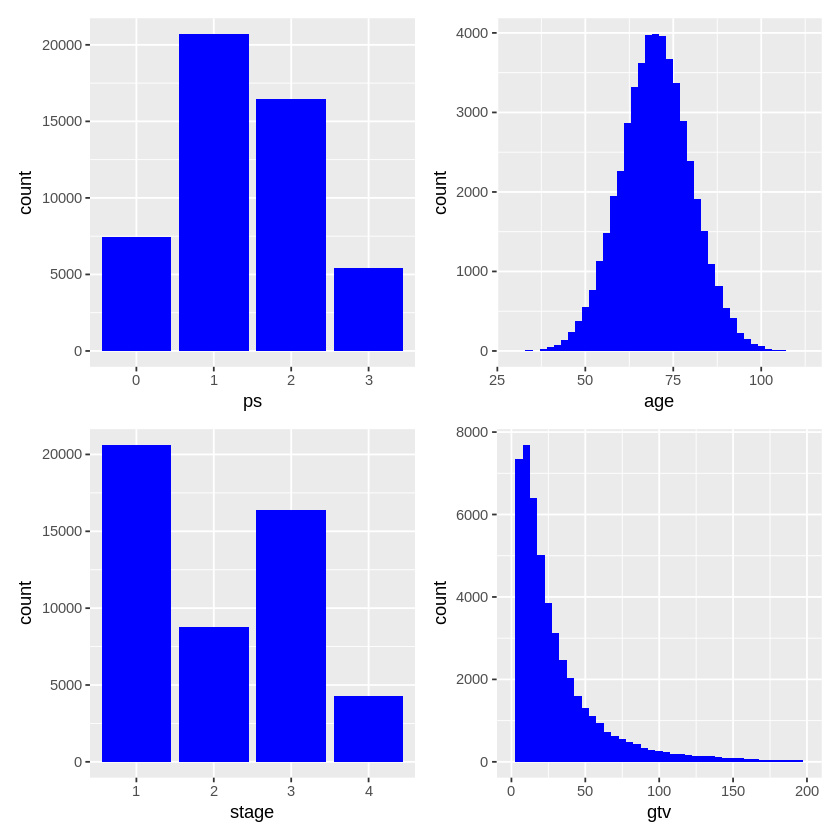

In [25]:
p1 = ggplot(population,aes(x=ps)) +
  geom_bar(stat='count', fill='blue')
p2 = ggplot(population,aes(x=age)) +
  geom_histogram(fill='blue',binwidth=2)
p3 = ggplot(population,aes(x=stage)) +
  geom_bar(stat='count', fill='blue')
p4 = ggplot(population,aes(x=gtv)) +
  geom_histogram(fill='blue',binwidth=5) +
  xlim(c(0,200))
p1+p2+p3+p4

Set different treatment HRs by patient age, sex, PS, stage. Regress against these values and add in some uncertainty in response.

First normalise variables then re-order if necessary so HR increases in the logical direction - more unhealthy the patient, the less their reponse.
HR of death when using the new treatment should run 0.6 -> 1 with some uncertainty (ie no one gets significantly more ill with the new intervention)



In [49]:
age_norm = (age-median(population$age))/(max(population$age)-min(population$age))
age_norm=age_norm-min(age_norm)
ps_norm = (as.numeric(population$ps)-median(as.numeric(population$ps)))/3
stage_norm = (as.numeric(population$stage)-1)/3
sex_norm = rep(0,length(population$sex))
sex_norm[which(population$sex == 'male')] = 1

hr_treat = abs((age_norm + ps_norm + sex_norm + stage_norm) + rnorm(n=popSize, mean=0, sd=0.1))
hr_treat = ((hr_treat-min(hr_treat)) / (max(hr_treat)-min(hr_treat))) *0.3 + 0.7 + rnorm(n=popSize, mean=0, sd=0.1)
population$hr_treat = hr_treat


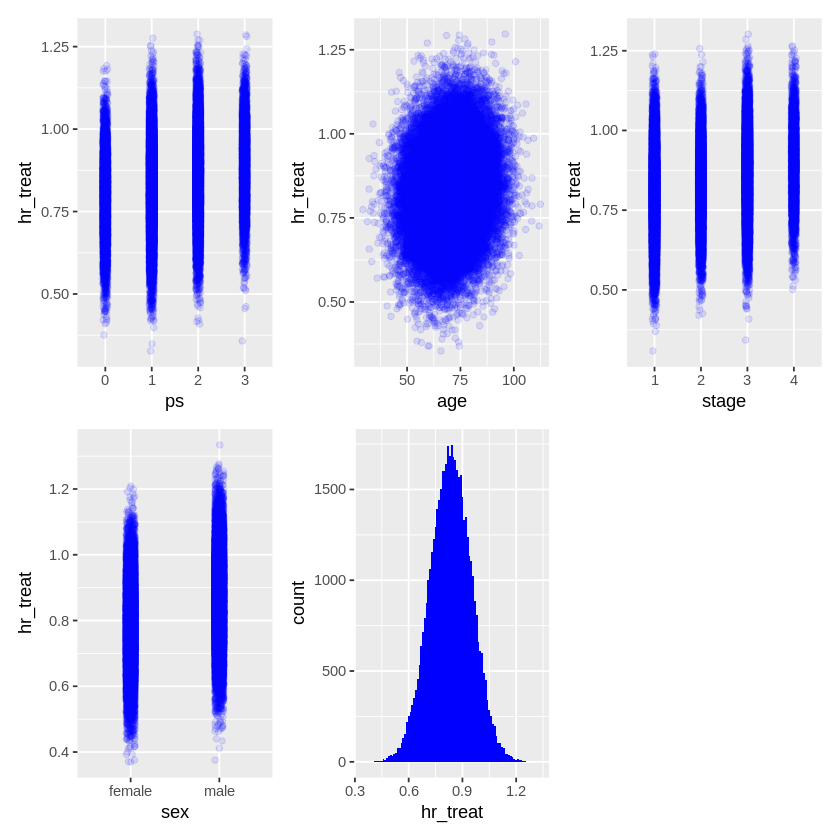

In [27]:
p1 = ggplot(data=population, aes(y=hr_treat)) +
  geom_point(aes(x=ps),alpha = 0.1, position=position_jitter(height=.05, width=.05),colour='blue')
p2 = ggplot(data=population, aes(y=hr_treat)) +
  geom_point(aes(x=age),alpha = 0.1, position=position_jitter(height=.05, width=.05),colour='blue')
p3 = ggplot(data=population, aes(y=hr_treat)) +
  geom_point(aes(x=stage),alpha = 0.1, position=position_jitter(height=.05, width=.05),colour='blue')
p4 = ggplot(data=population, aes(y=hr_treat)) +
  geom_point(aes(x=sex),alpha = 0.1, position=position_jitter(height=.05, width=.05),colour='blue')
p5 = ggplot(population,aes(x=hr_treat)) +
  geom_histogram(fill='blue',binwidth=0.01)
p1+p2+p3+p4+p5

Create time vector for period we are interested in (3 years)

In [28]:
time=seq(0,365*3)

Calculate cumulative baseline hazard

In [29]:
H_0 = h_0 * time

Create array of hazards as a function of time for different prognostic indicies

Hazard for patient i: h_i = H_0 * exp(B_i * x_i)

B_i *x_i = prognostic index for patient i



First calculate prognostic index for each patient

Natural log of HRs to create the beta coefficients

For continuous variables (eg age) the reference value is the mean, for categorical variables, reference (eg stage) is lowest risk



In [50]:
population$age_pi = (population$age - mean(population$age))*log(hr_age)

population$sex_pi = rep(log(1.0),popSize)
population$sex_pi[which(population$sex == 'male')] = rep(log(hr_sex),sum(population$sex == 'male'))

population$ps_pi = rep(log(1.0),popSize)
population$ps_pi[which(population$ps == 1)] = rep(log(hr_ps1),sum(population$ps == 1))
population$ps_pi[which(population$ps == 2)] = rep(log(hr_ps2),sum(population$ps == 2))
population$ps_pi[which(population$ps == 3)] = rep(log(hr_ps3),sum(population$ps == 3))

population$stage_pi = rep(log(1.0),popSize)
population$stage_pi[which(population$stage == 2)] = rep(log(hr_stage2),sum(population$stage == 2))
population$stage_pi[which(population$stage == 3)] = rep(log(hr_stage3),sum(population$stage == 3))
population$stage_pi[which(population$stage == 4)] = rep(log(hr_stage4),sum(population$stage == 4))

population$log_gtv_pi = (log(population$gtv) - mean(log(population$gtv)))*log(hr_gtv)

population$baseProgInd = population$age_pi + population$sex_pi + population$ps_pi + population$stage_pi + population$log_gtv_pi

Assign hospital each patient is treated in by applying some selection criteria with noise.

Assign patients to catchement area for:
* Hospital A serving a population from a wealthy, well educated region (younger, fitter, earlier stage patients)
* Hospital B seving a population from a more deprived, ex-inductrial region (older, frailer, later stage patients)

In [51]:
age_norm = (population$age-min(population$age))/(max(population$age)-min(population$age))
ps_norm = as.numeric(population$ps)/3
stage_norm = (as.numeric(population$stage)-1)/3

hospital = 1.2*age_norm + ps_norm + stage_norm + rnorm(n=popSize, mean=0, sd=0.3)
hospital = (hospital-min(hospital))/(max(hospital)-min(hospital))
population$hospital = rep('A',length(hospital))
population$hospital[which(hospital>median(hospital))]='B'

Save population data

In [52]:
write.csv(population,'simulatedPopulation.csv')

#Clinical scenarios
Provide new intervention under different scenarios and evaluate its impact on survival

Sample patients from the wider population to include in study

In [53]:
set.seed(86112)
patients=population[as.integer(runif(nbrPats)*popSize),]


##Treatment assigned by hospital


Hospital A introduces the new treatment for all patients

Assign treatment variable by hospital

In [54]:

patients$treat = rep('Standard of Care',nrow(patients))
patients$treat[which(patients$hospital=='A')]='Intervention'


Add treatment to prognostic index

In [55]:
patients$treat_pi = log(patients$hr_treat) * (patients$treat == 'Intervention')
patients$progInd = patients$baseProgInd + patients$treat_pi

Calculate the individual hazard per patient over time

In [36]:
hazard = array(dim=c(length(time),nrow=nbrPats))
for(i in 1:nbrPats){
  hazard[,i] =  H_0 * exp(patients$progInd[i])
}

Calculate survival probabilities per patient from their hazard and the baseline S_i = exp(-hazard)

Plot to see if it looks sensible



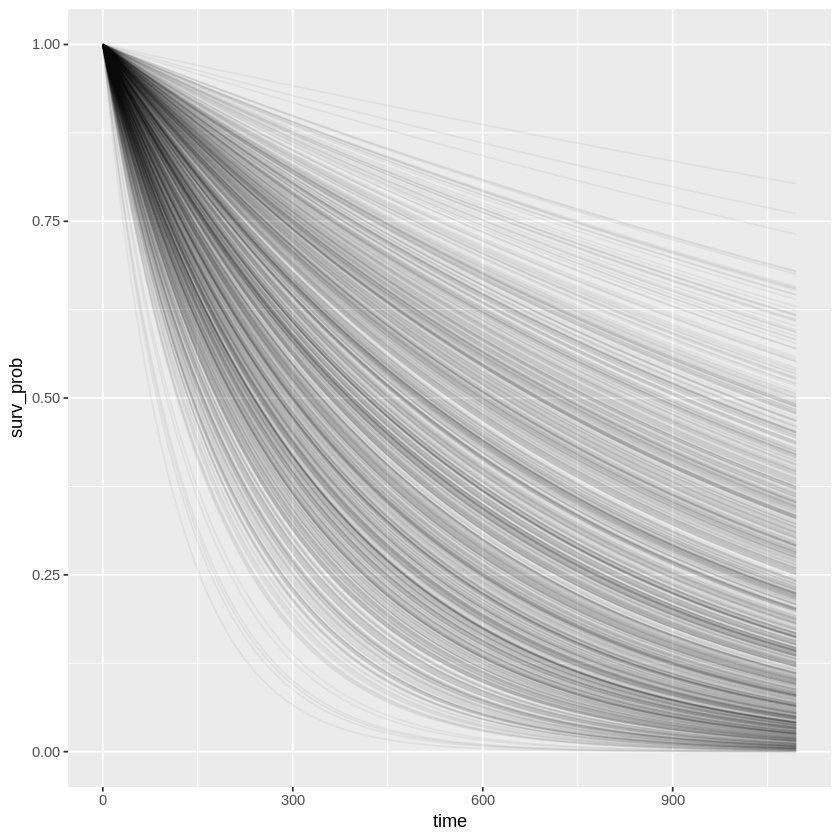

In [37]:
surv = exp(-hazard)
surv_df = data.frame(id=rep(seq(nbrPats), each=nrow(surv)), time=rep(time, ncol(surv)), surv_prob=as.vector(surv))
ggplot(data=surv_df,aes(x=time, y=surv_prob, group=id)) +
  geom_line(alpha=0.05)

Now need to simulate survival times by using probabilities taken from a uniform random number generator for each patient

They then survive until the corresponding time equating to the survival probability calculated from their individual hazard radio

S(t) = exp(-H_0(t) * exp(progInd)) where we calculate S(t) from random distribution for each patient

log(S(t)) = -h_0 * time * exp(progInd)

time = - log(S(t)) / h_0*exp(progInd)

In the first instance set all patinets to having an event (ie we know when all die). We can censoir later if required

In [56]:
survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rbinom(n=nrow(patients), size=1, prob=0.9)

Use ggplot to plot KM curve

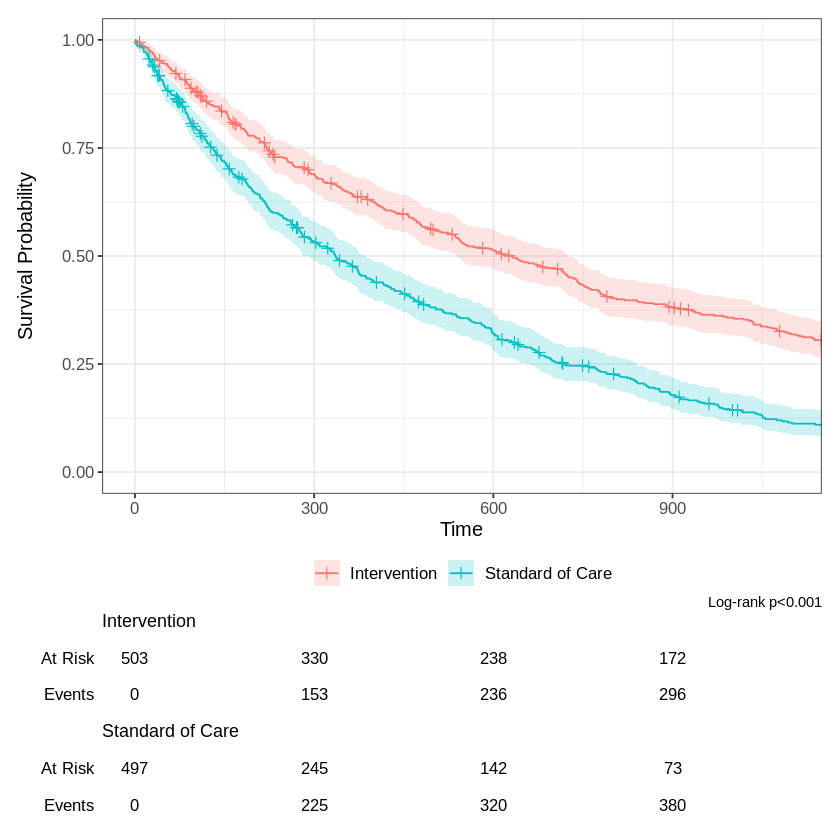

In [57]:
hospitalSurv = Surv(patients$survTime,patients$vitalStatus)

ggsurvfit(survfit2(hospitalSurv~treat, data=patients), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")


However, look at balance between those patients who recieved the new treatments (that attended hospital A) and those that didn't (that attended hospital B).

Note to get the below table to render (TODO: figure out how to render directly in notebook) you need to copy the html output to the empty text box below the code snippet

In [ ]:
print(table1(~ age + sex + ps + stage | treat, patients))



<table class="Rtable1">
<thead>
<tr>
<th class='rowlabel firstrow lastrow'></th>
<th class='firstrow lastrow'><span class='stratlabel'>Intervention<br><span class='stratn'>(N=500)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Standard of Care<br><span class='stratn'>(N=500)</span></span></th>
<th class='firstrow lastrow'><span class='stratlabel'>Overall<br><span class='stratn'>(N=1000)</span></span></th>
</tr>
</thead>
<tbody>
<tr>
<td class='rowlabel firstrow'>age</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>Mean (SD)</td>
<td>65.6 (9.18)</td>
<td>74.2 (9.15)</td>
<td>69.9 (10.1)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>Median [Min, Max]</td>
<td class='lastrow'>66.0 [39.7, 92.2]</td>
<td class='lastrow'>74.3 [46.0, 100]</td>
<td class='lastrow'>69.6 [39.7, 100]</td>
</tr>
<tr>
<td class='rowlabel firstrow'>sex</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>female</td>
<td>204 (40.8%)</td>
<td>189 (37.8%)</td>
<td>393 (39.3%)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>male</td>
<td class='lastrow'>296 (59.2%)</td>
<td class='lastrow'>311 (62.2%)</td>
<td class='lastrow'>607 (60.7%)</td>
</tr>
<tr>
<td class='rowlabel firstrow'>ps</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>0</td>
<td>126 (25.2%)</td>
<td>19 (3.8%)</td>
<td>145 (14.5%)</td>
</tr>
<tr>
<td class='rowlabel'>1</td>
<td>248 (49.6%)</td>
<td>161 (32.2%)</td>
<td>409 (40.9%)</td>
</tr>
<tr>
<td class='rowlabel'>2</td>
<td>112 (22.4%)</td>
<td>217 (43.4%)</td>
<td>329 (32.9%)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>3</td>
<td class='lastrow'>14 (2.8%)</td>
<td class='lastrow'>103 (20.6%)</td>
<td class='lastrow'>117 (11.7%)</td>
</tr>
<tr>
<td class='rowlabel firstrow'>stage</td>
<td class='firstrow'></td>
<td class='firstrow'></td>
<td class='firstrow'></td>
</tr>
<tr>
<td class='rowlabel'>1</td>
<td>302 (60.4%)</td>
<td>101 (20.2%)</td>
<td>403 (40.3%)</td>
</tr>
<tr>
<td class='rowlabel'>2</td>
<td>83 (16.6%)</td>
<td>90 (18.0%)</td>
<td>173 (17.3%)</td>
</tr>
<tr>
<td class='rowlabel'>3</td>
<td>107 (21.4%)</td>
<td>224 (44.8%)</td>
<td>331 (33.1%)</td>
</tr>
<tr>
<td class='rowlabel lastrow'>4</td>
<td class='lastrow'>8 (1.6%)</td>
<td class='lastrow'>85 (17.0%)</td>
<td class='lastrow'>93 (9.3%)</td>
</tr>
</tbody>
</table>



Plotted as graphs

Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


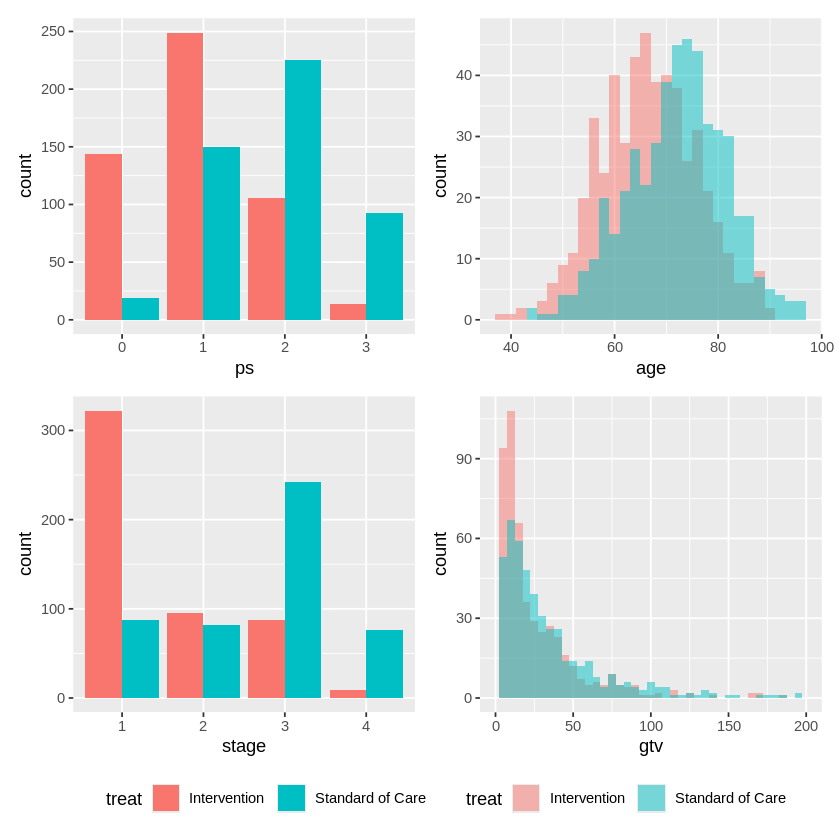

In [40]:
p1 = ggplot(patients,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

However, calculate the multivariable cox model and see what the regression coefficients say

In [58]:
hospitalCox = coxph(hospitalSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients)
summary(hospitalCox)

Call:
coxph(formula = hospitalSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients)

  n= 1000, number of events= 900 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.009385  1.009429 0.003836 2.447  0.01441 *  
sexmale               0.276630  1.318679 0.069736 3.967 7.28e-05 ***
ps1                   0.242675  1.274654 0.102050 2.378  0.01741 *  
ps2                   0.361302  1.435197 0.116202 3.109  0.00188 ** 
ps3                   0.661698  1.938080 0.152054 4.352 1.35e-05 ***
stage2                0.243851  1.276154 0.100220 2.433  0.01497 *  
stage3                0.475115  1.608199 0.099217 4.789 1.68e-06 ***
stage4                0.808332  2.244162 0.143962 5.615 1.97e-08 ***
log(gtv)              0.308671  1.361614 0.036331 8.496  < 2e-16 ***
treatStandard of Care 0.072904  1.075627 0.100082 0.728  0.46634    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(coef) exp

##Treatment assigned randomly to all patients
In the next scenario, treatment is assigned randonly to all patients

The randomisation balances the groups meaning the log-rank test results closely agree with the multivariable regression

Create the new survival data

In [59]:
patients$treat = rep('Standard of Care',nbrPats)
patients$treat[which(runif(nbrPats)>0.5)]='Intervention'

patients$treat_pi = log(patients$hr_treat) * (patients$treat == 'Intervention')
patients$progInd = patients$baseProgInd + patients$treat_pi

survProb = runif(nbrPats,0,1)
patients$survTime = -log(survProb) / (h_0 * exp(patients$progInd))
patients$vitalStatus = rbinom(n=nrow(patients), size=1, prob=0.9)

Look at KM curve

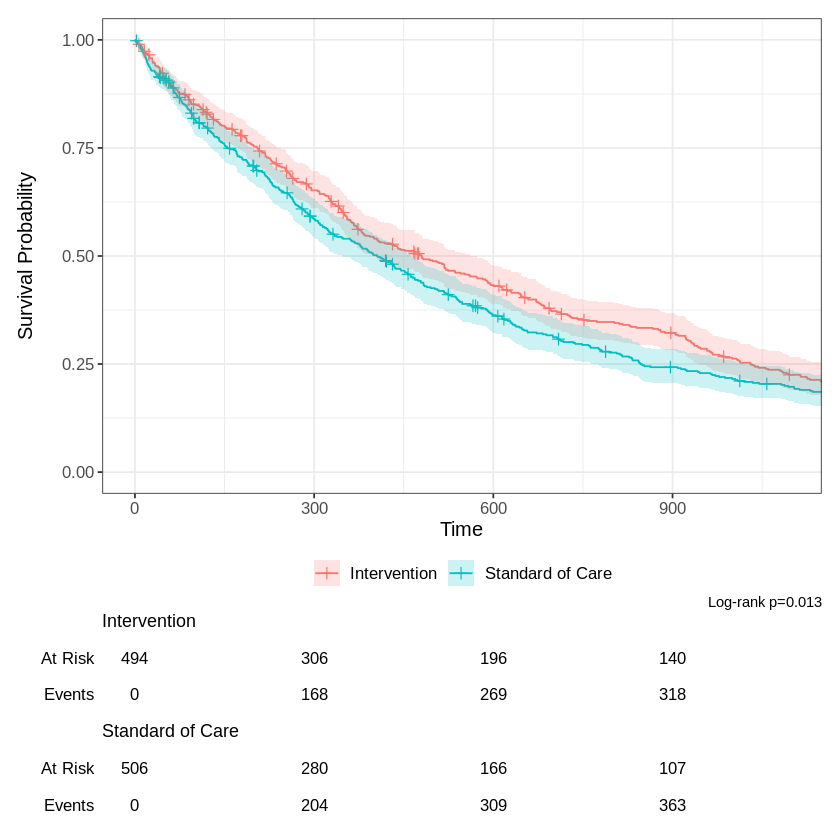

In [60]:
randSurv = Surv(patients$survTime,patients$vitalStatus)

ggsurvfit(survfit2(randSurv~treat, data=patients), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")


Plot balance of groups

Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


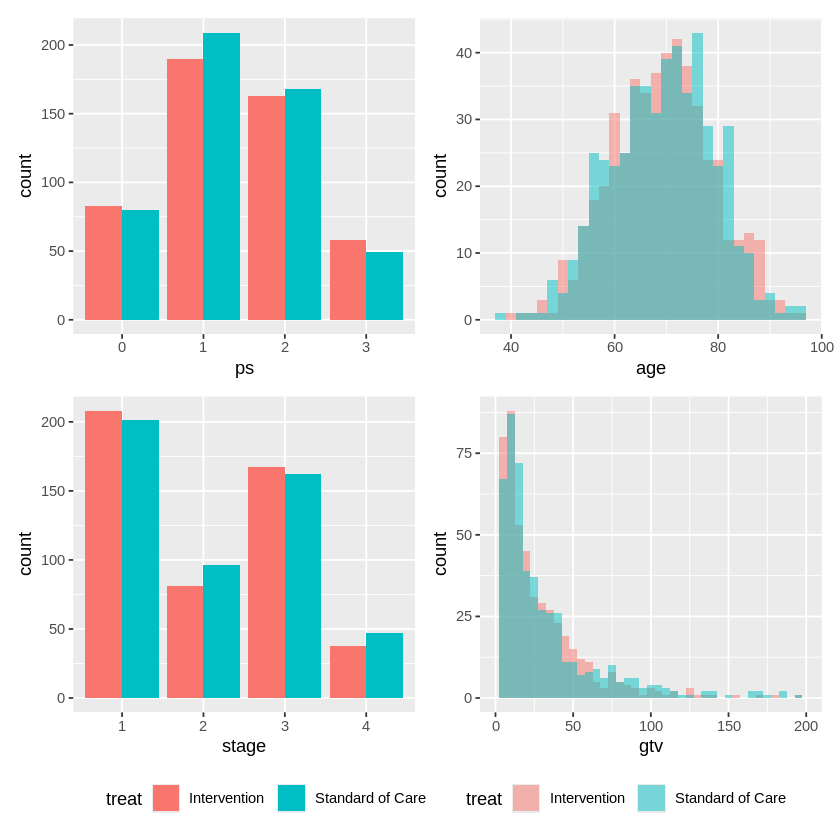

In [61]:
p1 = ggplot(patients,aes(x=ps, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p2 = ggplot(patients,aes(x=age, group=treat, fill=treat)) +
  geom_histogram(binwidth=2,position = 'identity',alpha=0.5)
p3 = ggplot(patients,aes(x=stage, group=treat, fill=treat)) +
  geom_bar(stat='count',position='dodge')
p4 = ggplot(patients,aes(x=gtv, group=treat, fill=treat)) +
  geom_histogram(binwidth=5,position = 'identity',alpha=0.5) +
  xlim(0, 200)

combined <- p1 + p2 +p3 + p4 & theme(legend.position = "bottom")
combined + plot_layout(guides = "collect")

Check multi variable analysis

In [62]:
randCox = coxph(randSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients)
summary(randCox)

Call:
coxph(formula = randSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients)

  n= 1000, number of events= 906 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.015123  1.015238 0.003575 4.230 2.33e-05 ***
sexmale               0.300066  1.349948 0.069950 4.290 1.79e-05 ***
ps1                   0.338206  1.402430 0.098293 3.441  0.00058 ***
ps2                   0.440890  1.554089 0.105690 4.172 3.03e-05 ***
ps3                   0.749865  2.116715 0.133480 5.618 1.93e-08 ***
stage2                0.257357  1.293507 0.096783 2.659  0.00783 ** 
stage3                0.486820  1.627134 0.083339 5.841 5.17e-09 ***
stage4                0.838056  2.311868 0.129084 6.492 8.45e-11 ***
log(gtv)              0.276896  1.319029 0.038441 7.203 5.89e-13 ***
treatStandard of Care 0.143568  1.154385 0.067322 2.133  0.03296 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(coef) exp(-co

##Randomisation with selection criteria
In the final scenario we demonstrate why trials have selection criteria. As some patients respond differently to the new treatment, selection of only those patients expected to respond positively to the intervention can lead to more impressive results

Limit the treatment to those patients with
* Performance status 0-1
* Stage 1-3

In [63]:
patients_included = population %>%
  dplyr::filter((ps == 0 | ps ==1) & (stage == 1 | stage == 2)) %>%
  slice_sample(n=nbrPats)

Randomise this subset of patients and repeat the analysis

In [64]:
patients_included$treat = rep('Standard of Care',nbrPats)
patients_included$treat[which(runif(nbrPats)>0.5)]='Intervention'

patients_included$treat_pi = log(patients_included$hr_treat) * (patients_included$treat == 'Intervention')
patients_included$progInd = patients_included$baseProgInd + patients_included$treat_pi

survProb = runif(nbrPats,0,1)
patients_included$survTime = -log(survProb) / (h_0 * exp(patients_included$progInd))
patients_included$vitalStatus = rbinom(n=nbrPats, size=1, prob=0.9)

Look at KM curve and Cox regression, check cohort balance

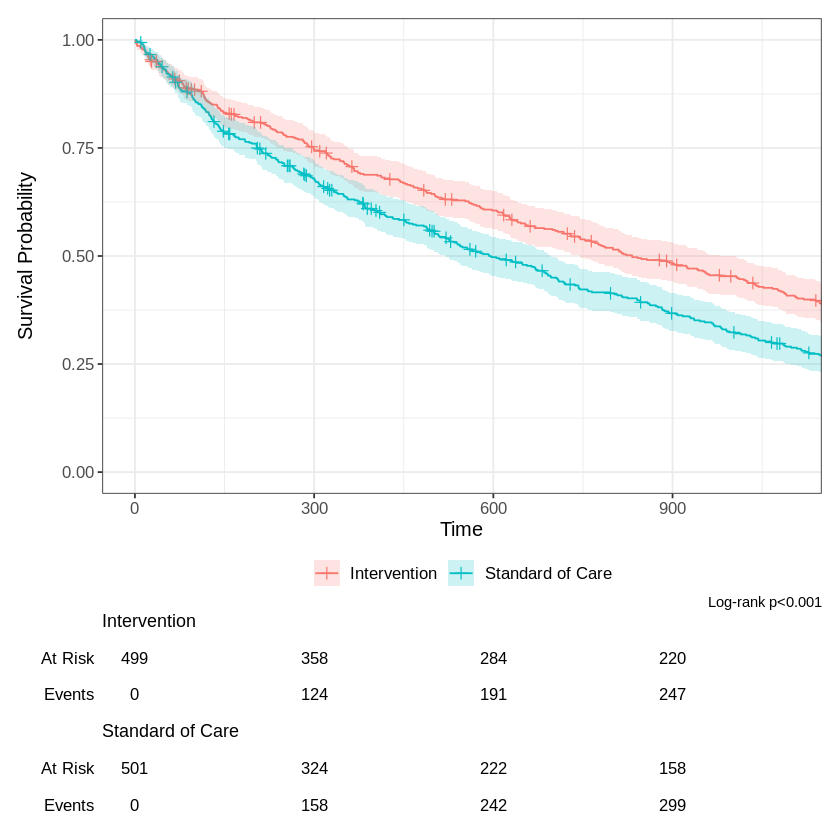

In [65]:
selectSurv = Surv(patients_included$survTime,patients_included$vitalStatus)

ggsurvfit(survfit2(selectSurv~treat, data=patients_included), type = "survival") +
  add_censor_mark() +
  add_confidence_interval() +
  add_risktable() +
  coord_cartesian(xlim = c(0, 365 * 3)) +
  add_pvalue(caption = "Log-rank {p.value}")

In [66]:
selectCox = coxph(selectSurv~ age + sex + ps + stage + log(gtv) + treat, data=patients_included)
summary(selectCox)

Call:
coxph(formula = selectSurv ~ age + sex + ps + stage + log(gtv) + 
    treat, data = patients_included)

  n= 1000, number of events= 883 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
age                   0.007580  1.007609 0.003603 2.104 0.035371 *  
sexmale               0.252685  1.287478 0.070100 3.605 0.000313 ***
ps1                   0.374893  1.454835 0.077445 4.841 1.29e-06 ***
ps2                         NA        NA 0.000000    NA       NA    
ps3                         NA        NA 0.000000    NA       NA    
stage2                0.367466  1.444071 0.074918 4.905 9.35e-07 ***
stage3                      NA        NA 0.000000    NA       NA    
stage4                      NA        NA 0.000000    NA       NA    
log(gtv)              0.338230  1.402462 0.036408 9.290  < 2e-16 ***
treatStandard of Care 0.361441  1.435396 0.068853 5.249 1.53e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                      exp(co